<a href="https://colab.research.google.com/github/SatoshiNakamora/AI-projects/blob/main/%5B2025_06_01%5D_Intro_to_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to AI Agents: Getting Started with OpenAI’s Assistants API

Welcome to our 2-hour workshop on AI agents! This notebook introduces the concept of AI agents and guides you through building a simple agent using OpenAI’s Assistants API. Designed for data scientists with limited exposure to large language models (LLMs) or agents, this session will help you understand what agents are, how they work, and how to create one. Let’s dive in with a fun demo and hands-on coding!

## Agenda for This Notebook (~2 hours)

1. **What Are AI Agents?**
   - Why Should Data Scientists Care?
   - Quick Demo: A Math Helper Agent  
2. **Core Components of an Agent**  
3. **Setting Up the Environment**  
   - Prerequisites  
   - Getting Familiar with the API  
4. **Building a Simple Agent with OpenAI Agent SDK**
   - Step 1: Create a Basic Agent  
   - Step 2: Add Some Tools  
5. **Multi-Agent Collaboration Example**
   - Triage Agent  
   - Manager Agent  
6. **Under the Hood: Building an Agent *without* the Agents SDK**  
7. **🚀 Loading a Local LLM with vLLM**
   - What You'll Need  
   - Resources  
8. **[Advanced] Flexible EDA Agent (tool-driven, no hard-coded analysis)**  
9. **[Advanced] Model Context Protocol (MCP) Demo — Google Sheets Tool**


## 1. What Are AI Agents?

AI agents are autonomous systems that perceive their environment (e.g., user input), reason about it using an LLM, and take actions (e.g., generate responses or call tools). Unlike traditional ML models, agents combine LLMs with memory (to track conversations) and tools (to perform tasks like calculations or API calls). They’re like intelligent assistants that can handle complex, multi-step tasks.


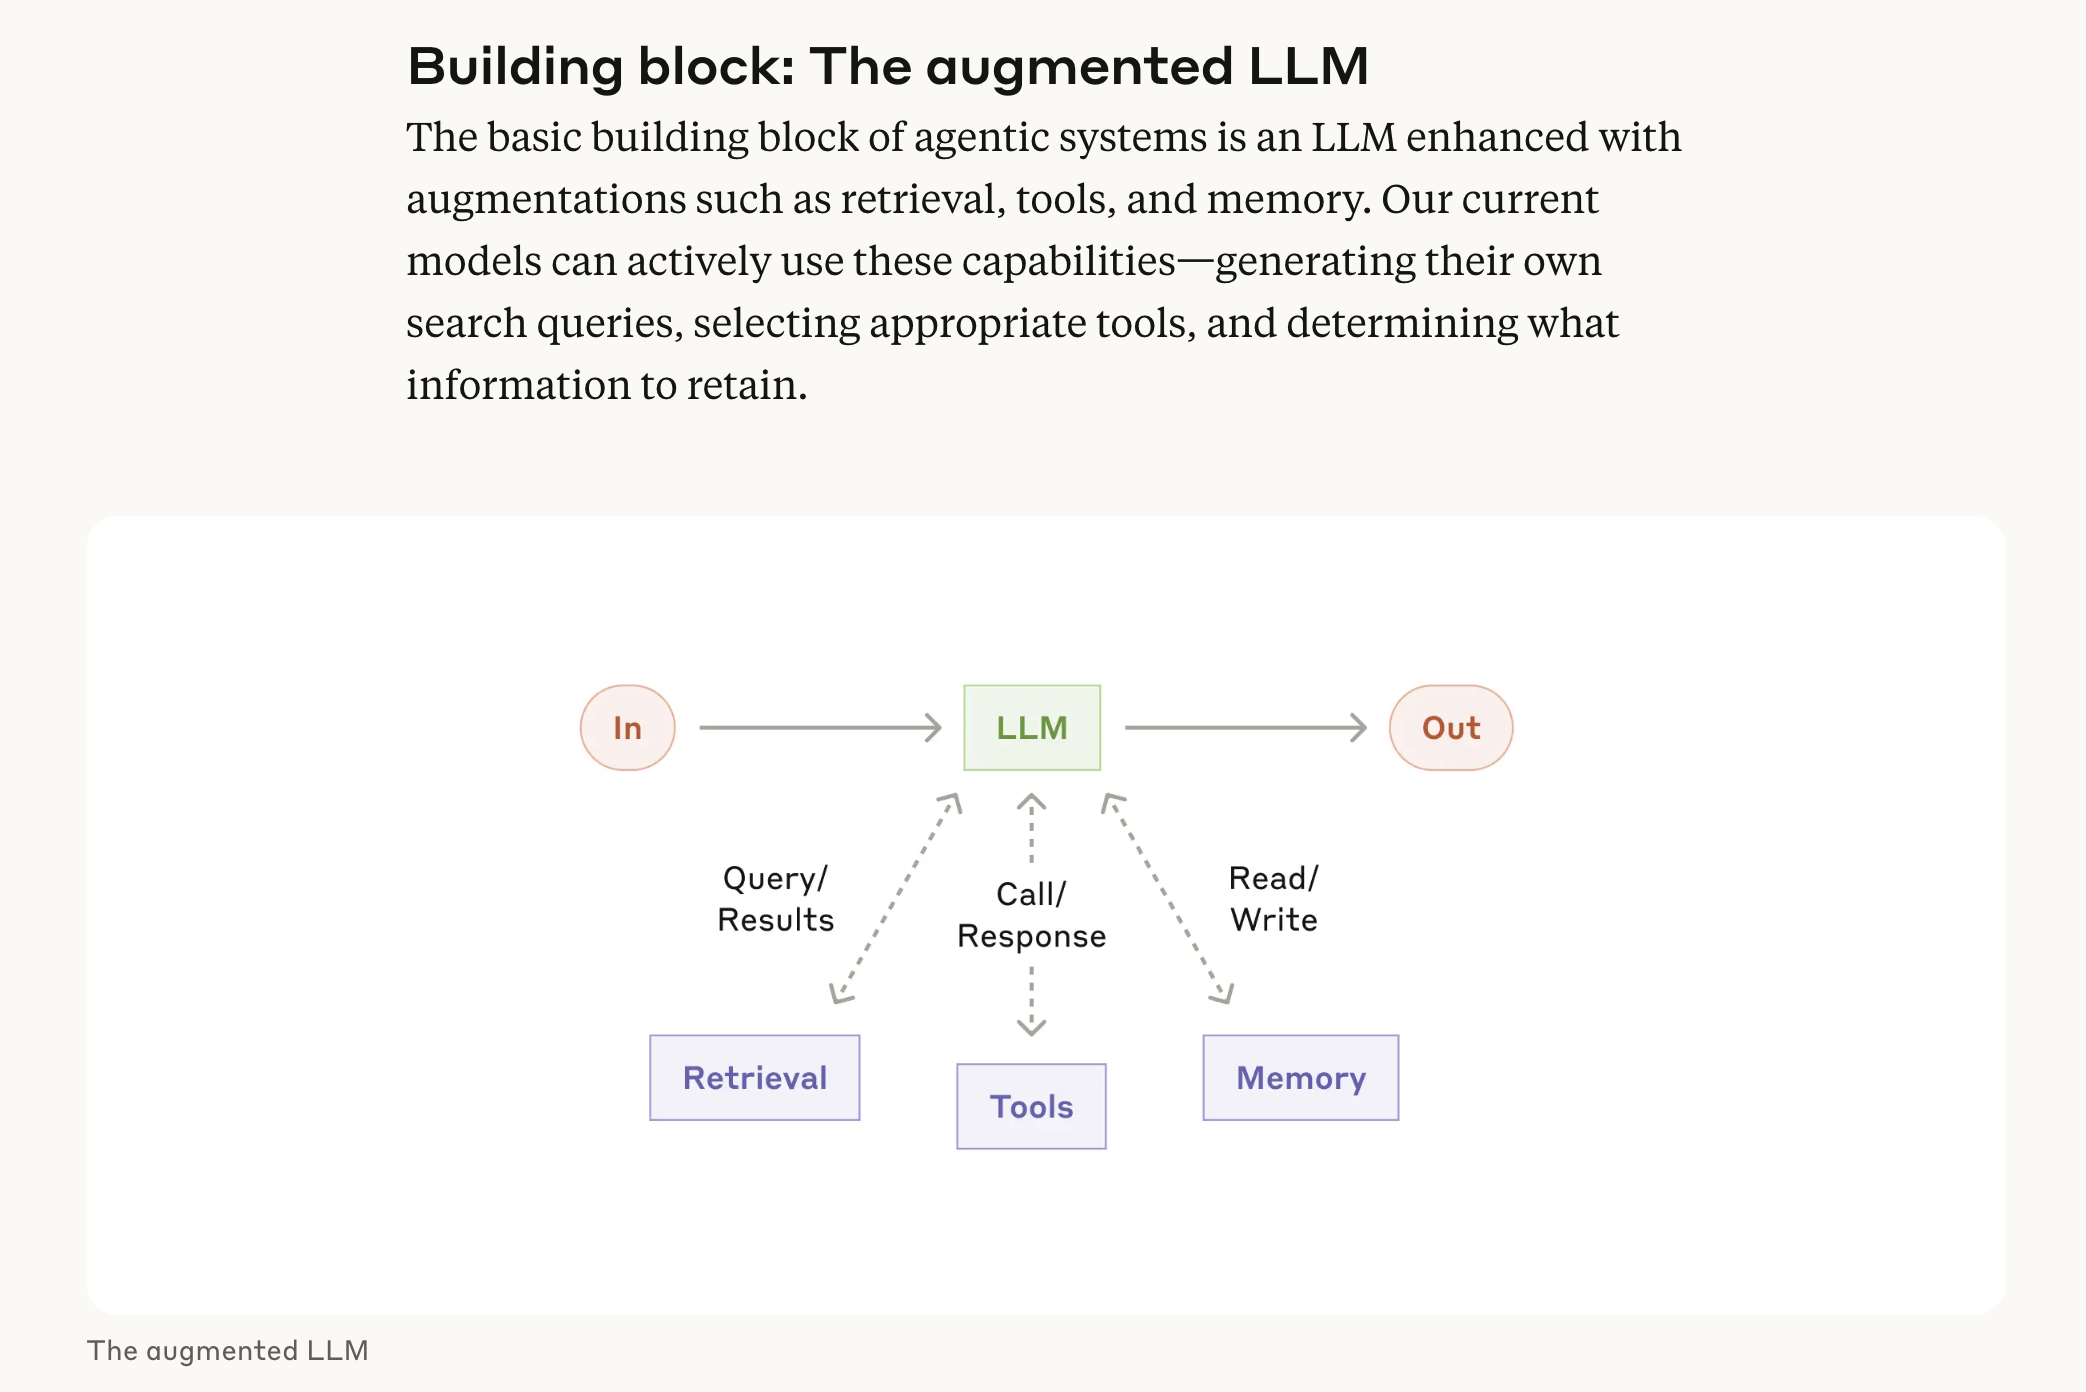

Courtesy: https://www.anthropic.com/engineering/building-effective-agents

### Why Should Data Scientists Care?
- **Automation**: Agents can automate repetitive tasks, like answering questions or analyzing data.
- **Scalability**: They can handle dynamic inputs and adapt to new contexts.
- **Real-World Impact**: Use cases include customer support bots, data analysis assistants, and task planners.

### [Optional] Quick Start: OpenAI API Signup & Credits
We will be using OpenAI API for the majority of this notebook. To sign up for one, following the below:

1. Create an OpenAI Account
Go to https://platform.openai.com/signup

Use your email or sign in with Google/Microsoft

2. Verify Your Email & Phone
OpenAI requires both email and phone verification

Ensure you're using a non-VoIP number (e.g., not Google Voice)

3. Access the API Dashboard
Visit: https://platform.openai.com/account/api-keys

Click “Create new secret key” to generate your API key

4. Check Your Usage and Credits
Go to: https://platform.openai.com/account/usage

Free-tier users may receive initial trial credits (e.g., 5 to 18 dollars depending on promotions)

5. Subscribe for More Usage (Optional)
Upgrade to a Pay-as-you-go plan under https://platform.openai.com/account/billing

Add a payment method to enable paid access if credits run out



## 2. Core Components of an Agent

An AI agent typically consists of three key components:
- **Perception**: Processing user input (e.g., text questions).
- **Reasoning**: Using an LLM to interpret the input and decide on actions.
- **Action**: Generating a response or calling external tools (e.g., a calculator).

Here’s a simple diagram of how these components interact:

```
[User Input] → [Perception: Tokenize & Process] → [Reasoning: LLM] → [Action: Response or Tool Call] → [Output]
```

For example, in our math helper agent:
- **Input**: “What’s the square root of 16?”
- **Perception**: The agent tokenizes and understands the question.
- **Reasoning**: The LLM decides the question requires a calculation.
- **Action**: The agent calls a square root function and returns “4”.

We’ll use OpenAI’s Assistants API, which simplifies building agents by handling conversation history and tool integration. Let’s set up our environment to try it out!

## 3. Setting Up the Environment

To build our agent, we need the OpenAI Python SDK and an API key. Follow these steps to set up your environment.

### Prerequisites
- Python 3.8+
- OpenAI API key (provided in the pre-workshop setup guide or sign up at [https://platform.openai.com/](https://platform.openai.com/)).
- Install the required library: `openai`.

Let’s install the library and set up our API key.


In [ ]:
# Install the OpenAI SDK
!pip install openai

In [ ]:
# Import the OpenAI library
from openai import OpenAI
import os

# Set your OpenAI API key
# Replace 'your-api-key' with your actual key (keep it secure!)
# I will read api key from my secret.txt
with open('secret.txt', 'r') as f:
    API_KEY = f.read().strip()

API_MODEL_NAME = "gpt-4o-mini"

os.environ["OPENAI_API_KEY"] = API_KEY
client = OpenAI()

**Note**: If you don’t have an API key, don’t worry! You can follow along with the code and outputs. In Notebook 2, we’ll explore a local LLM option that doesn’t require an API key.

**Play Around**: Verify your setup by printing the OpenAI client object. It should look something like `<openai.OpenAI object at ...>`.
Alternatively, let's chat with it!

### Getting Familiar with the API

- APIs are the primary way developers interact with and leverage language models.
- Refer to [OpenAI's Quickstart Guide](https://platform.openai.com/docs/quickstart?api-mode=responses) to get started.
- Explore common API modes:
  - **Completion**
  - **Chat**
  - **Images**
  - **Streaming**
  - **And more**

In [ ]:
# Simple response
response = client.responses.create(
    model=API_MODEL_NAME,
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

Once upon a time, beneath a sky filled with shimmering stars, a gentle unicorn named Luna danced through a moonlit forest, spreading dreams and magic wherever she trod.


In [ ]:
# Chat
chat_res = client.responses.create(
    model=API_MODEL_NAME,
    input=[
        {
            "role": "user",
            "content": "What is 2+2?",
        },
        {
            "role": "assistant",
            "content": "2+2 is 4.",
        },
        {
            "role": "user",
            "content": "and if we multiply that by 10?",
        }
    ],
)

print(chat_res.output_text)

If you multiply 4 by 10, you get 40.


In [ ]:
# Streaming
stream = client.responses.create(
    model=API_MODEL_NAME,
    input=[
        {
            "role": "user",
            "content": "Say 'double bubble bath' 100 times fast.",
        },
    ],
    stream=True,
)

for event in stream:
  if hasattr(event, 'delta'):
    print(event.delta, end="")

That’s a fun tongue twister! While I can’t say it out loud, you can definitely give it a try yourself! Just remember to take your time and have fun with it.

## 4. Building a Simple Agent with OpenAI Agent SDK

Let’s create a basic agent and then enhance it with a tool. We’ll start with a haiku generator and then build a search agent that saves results.

- Note that there are many great Agents libraries out there -- we will use OpenAI's for simplicity and convenience. See their Agents SDK documentation here:
https://openai.github.io/openai-agents-python/

First, Let’s install the library and set up our environment.

In [ ]:
# Install the OpenAI Agent SDK
!pip install openai-agents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


## 4. Building a Simple Agent with OpenAI Agent SDK

Let’s create a basic agent and then enhance it with a tool. We’ll start with a haiku generator and then build a search agent that saves results.

### Step 1: Create a Basic Agent
Let’s make an agent that writes a haiku about recursion in programming.

- The `Agent` class takes a `name` and `instructions` to define its behavior.
- `Runner.run` executes the agent with a prompt and returns the result.
- **IMPORTANT** make sure you have run `os.environ["OPENAI_API_KEY"] = API_KEY`, as the Agent SDK needs this to use your API.


In [ ]:
# Import required modules
from agents import Agent, Runner
from datetime import datetime

# Try this: Print the Agent class type
print(Agent)

<class 'agents.agent.Agent'>


In [ ]:
# Create a basic agent
agent = Agent(name="Haiku Poet",
              instructions="You are a helpful assistant that writes haikus about programming topics."
              )

# Run the agent -- note than `run()` is an async action
result = await Runner.run(agent, "Write a haiku about recursion in programming.")
print(result.final_output)

Function calls itself,  
Deep echo in code’s mirror—  
Infinite descent.


### Step 2: Add Some Tools
Now, let’s create a search agent that uses a tool search the internet and to do simple multiplication of numbers. Here's how you would equip the agent defined above with a series of tools when using the Agents SDK:
- `@function_tool` registers a function as a tool the agent can use.


In [ ]:
from agents import Agent, WebSearchTool, function_tool, FunctionTool
import json
from typing import List

# Define a simple calculator tool for multiplication
@function_tool
def calculator_multiply_numbers(numbers: List[float]) -> float:
  result = 1
  for number in numbers:
    result *= number

  return result

# Create a search agent with tools
search_agent = Agent(
    name="Calculator Agent",
    instructions="Help the user perform simple math and search the internet.",
    tools=[WebSearchTool(), calculator_multiply_numbers]
)

In [ ]:
# Let's validate the tool schema under the hood (helpful for debugging)
for tool in search_agent.tools:
    if isinstance(tool, FunctionTool):
        print(tool.name)
        print(tool.description)
        print(json.dumps(tool.params_json_schema, indent=4))
        print()

calculator_multiply_numbers

{
    "properties": {
        "numbers": {
            "items": {
                "type": "number"
            },
            "title": "Numbers",
            "type": "array"
        }
    },
    "required": [
        "numbers"
    ],
    "title": "calculator_multiply_numbers_args",
    "type": "object",
    "additionalProperties": false
}



In [ ]:
# Run the agent
result = await Runner.run(search_agent, "What is the current president's age times 2?")
print(result.final_output)

The current U.S. president, Donald Trump, is 78 years old. His age multiplied by 2 is 156.


In [ ]:
 # Let's dig into what happened to get this answer
 result.to_input_list()

[{'content': "What is the current president's age times 2?", 'role': 'user'},
 {'id': 'ws_683bb1b5cd7c8191a45f1e90a8f861640927d7eb6b96645c',
  'status': 'completed',
  'type': 'web_search_call'},
 {'id': 'msg_683bb1b724b081918def6e0979eb78f40927d7eb6b96645c',
  'content': [{'annotations': [{'end_index': 206,
      'start_index': 124,
      'title': 'Donald Trump',
      'type': 'url_citation',
      'url': 'https://en.wikipedia.org/wiki/Donald_Trump?utm_source=openai'}],
    'text': 'As of June 1, 2025, the current U.S. president is Donald Trump, who was born on June 14, 1946. This makes him 78 years old. ([en.wikipedia.org](https://en.wikipedia.org/wiki/Donald_Trump?utm_source=openai)) Multiplying his age by 2 gives 156. ',
    'type': 'output_text'}],
  'role': 'assistant',
  'status': 'completed',
  'type': 'message'},
 {'arguments': '{"numbers":[78,2]}',
  'call_id': 'call_ecvqLpSGS9FzCVWiE6cGq7bo',
  'name': 'calculator_multiply_numbers',
  'type': 'function_call',
  'id': 'fc_683

## Multi-Agent Collaboration Example

In this section, we demonstrate two multi-agent system patterns:

1. **Routing Pattern:** A Triage Agent determines the topic and routes the question to a specialized agent.
2. **Manager Pattern:** A Manager Agent breaks down a complex question into subtasks, delegates them to sub-agents, then aggregates the results.

There are many multi-agent patterns, but we will use these as core examples:

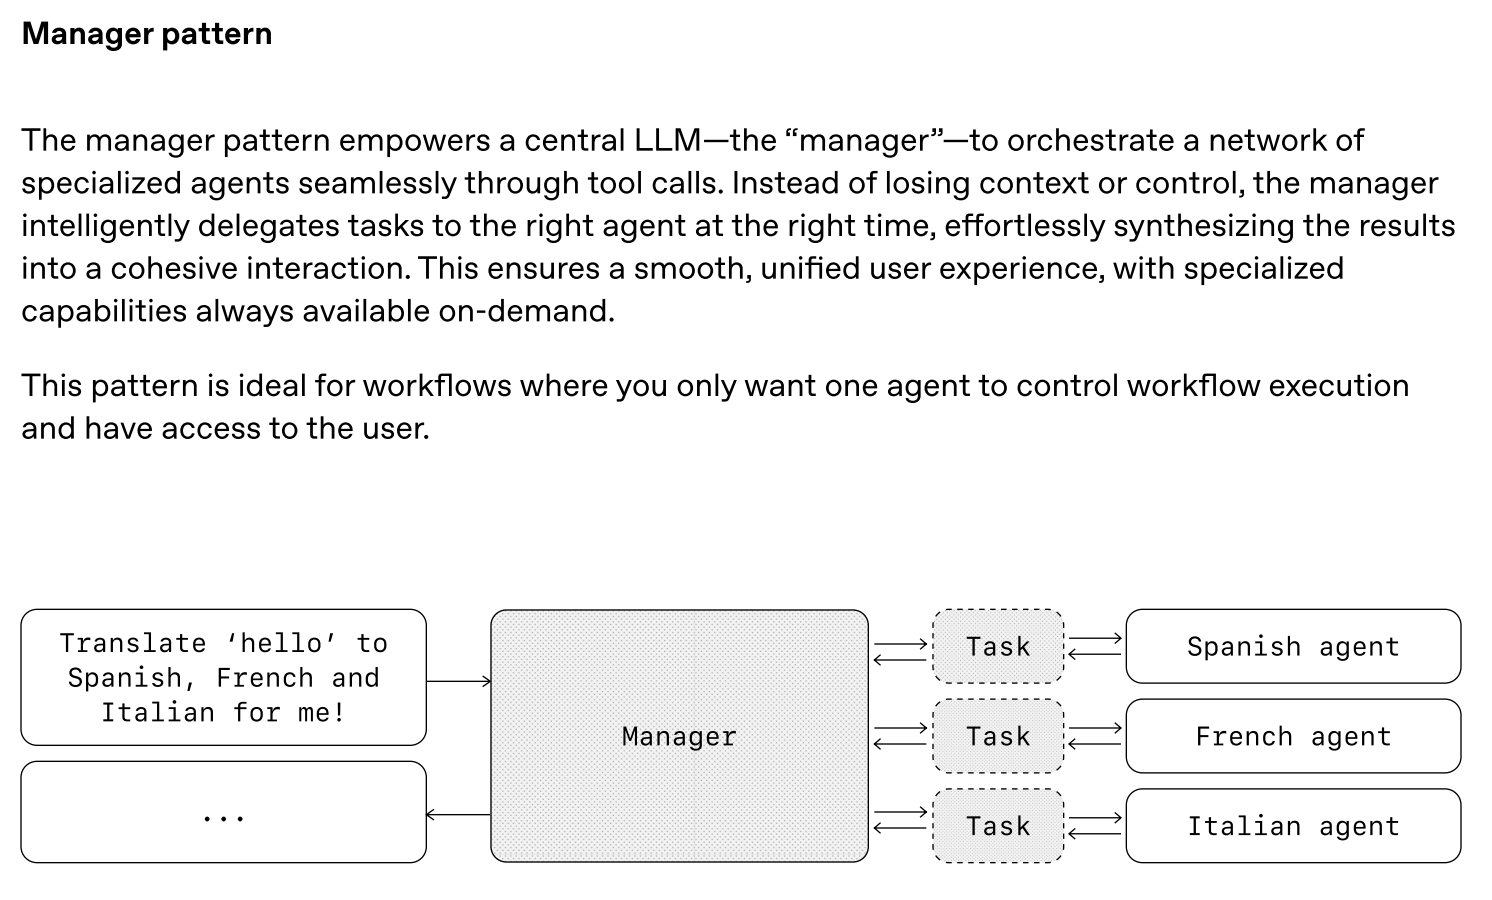

Courtesy: https://cdn.openai.com/business-guides-and-resources/a-practical-guide-to-building-agents.pdf

### Triage Agent
**Scenario:** The triage agent receives user questions and forwards them to either a Math Tutor or a History Tutor based on topic relevance.

In [ ]:
# Specialized agents
math_agent = Agent(
    name="Math Tutor",
    instructions="You are a helpful math tutor. You help students understand math problems and guide them through solutions."
)

history_agent = Agent(
    name="History Tutor",
    instructions="You are a knowledgeable history tutor. You answer historical questions with context and explanations."
)

# Triage agent with handoffs
triage_agent = Agent(
    name="Triage Agent",
    instructions="""
You are a triage assistant. When a user asks a question, determine if it's about math or history.
If it's math-related, hand off to the Math Tutor.
If it's history-related, hand off to the History Tutor.
""",
    handoffs=[math_agent, history_agent]
)

# User query example
query = "Who was the emperor of Rome during the eruption of Mt. Vesuvius?"

# Run the triage agent
result = await Runner.run(triage_agent, query)
print("Final Output:", result.final_output)

Final Output: The emperor of Rome during the eruption of Mount Vesuvius in 79 AD was Titus. Titus Flavius Vespasianus, commonly known as Titus, was the first Roman emperor to succeed his biological father, Vespasian, following a four-year period of joint rule with him. The eruption of Vesuvius was one of the significant events during his brief reign, as it led to the destruction of the Roman cities of Pompeii, Herculaneum, and others around the Bay of Naples. 

Titus is remembered for his effective and compassionate response to the disaster, as he organized large-scale relief efforts for the affected populations. His reign also included the completion of the Colosseum and efforts to address other natural disasters, including a fire in Rome and a plague outbreak.


In [ ]:
# What happened under the hood?
result.to_input_list()

[{'content': 'Who was the emperor of Rome during the eruption of Mt. Vesuvius?',
  'role': 'user'},
 {'arguments': '{}',
  'call_id': 'call_fcjzZV681qwei4xfbmuboWud',
  'name': 'transfer_to_history_tutor',
  'type': 'function_call',
  'id': 'fc_683bb1d5476081a3b9610a4bac930b940142f2e318dfb243',
  'status': 'completed'},
 {'call_id': 'call_fcjzZV681qwei4xfbmuboWud',
  'output': "{'assistant': 'History Tutor'}",
  'type': 'function_call_output'},
 {'id': 'msg_683bb1d5ce7881a38600852ccef71ea10142f2e318dfb243',
  'content': [{'annotations': [],
    'text': 'The emperor of Rome during the eruption of Mount Vesuvius in 79 AD was Titus. Titus Flavius Vespasianus, commonly known as Titus, was the first Roman emperor to succeed his biological father, Vespasian, following a four-year period of joint rule with him. The eruption of Vesuvius was one of the significant events during his brief reign, as it led to the destruction of the Roman cities of Pompeii, Herculaneum, and others around the Bay o

### Manager Agent
**Scenario:** The manager agent receives user questions and breaks it down into sub-tasks for the specialized agents to tackle.

In [ ]:
# Sub-agents for multi-step reasoning
define_agent = Agent(
    name="Definition Agent",
    instructions="You define technical terms in the user's question."
)

research_agent = Agent(
    name="Research Agent",
    instructions="You look up factual details relevant to the user's query."
)

summarize_agent = Agent(
    name="Summary Agent",
    instructions="You write a concise and accurate summary based on the inputs from other agents."
)

# Manager agent that coordinates the whole workflow
manager_agent = Agent(
    name="Manager Agent",
    instructions="""You are a project manager. When given a complex question, break it into subtasks.
1. Ask the Definition Agent to define key terms.
2. Ask the Research Agent to gather background facts.
3. Ask the Summary Agent to write a final answer using the previous outputs.

Include all sub-agent outputs in your response before presenting the final summary.
""",
    handoffs=[define_agent, research_agent, summarize_agent]
)

complex_query = "Explain the role of the Treaty of Versailles in causing World War II."
result = await Runner.run(manager_agent, complex_query)
print("Manager Pattern Output:\n", result.final_output)

Manager Pattern Output:
 The Treaty of Versailles, signed in 1919, ended World War I and imposed heavy reparations and territorial losses on Germany. Its harsh terms caused economic hardship and political instability in Germany, contributing to widespread resentment and the rise of Adolf Hitler. The treaty's punitive measures and the resulting sense of humiliation and injustice fueled nationalist sentiments, setting the stage for World War II.


In [ ]:
 result.to_input_list()

[{'content': 'Explain the role of the Treaty of Versailles in causing World War II.',
  'role': 'user'},
 {'arguments': '{}',
  'call_id': 'call_vMeBrrMYomV4F7fLPsBF7mMS',
  'name': 'transfer_to_definition_agent',
  'type': 'function_call',
  'id': 'fc_683bb22f99a0819f9af1ef88c5cb49c803a7d92823ab5d6c',
  'status': 'completed'},
 {'arguments': '{}',
  'call_id': 'call_4mRznB5us9Eo1S7dJ9KvRo4U',
  'name': 'transfer_to_research_agent',
  'type': 'function_call',
  'id': 'fc_683bb22fb30c819fb2fa5ac0b9717afd03a7d92823ab5d6c',
  'status': 'completed'},
 {'call_id': 'call_4mRznB5us9Eo1S7dJ9KvRo4U',
  'output': 'Multiple handoffs detected, ignoring this one.',
  'type': 'function_call_output'},
 {'call_id': 'call_vMeBrrMYomV4F7fLPsBF7mMS',
  'output': "{'assistant': 'Definition Agent'}",
  'type': 'function_call_output'},
 {'id': 'msg_683bb2302a50819fbfd9da601f95391103a7d92823ab5d6c',
  'content': [{'annotations': [],
    'text': "The Treaty of Versailles, signed in 1919, ended World War I and

## Under the Hood: Building an Agent *without* the Agents SDK

This example shows a minimal agent loop that uses the raw OpenAI
`responses.create` API, a couple of hand-written tools, and a tiny
controller class (`MiniAgent`) to orchestrate everything.

Key points
* Tools are just Python callables; the agent tells the model **which**
  tools exist and **how** to call them (JSON schema in the system prompt).
* After each model turn we inspect `tool_call` entries, execute them,
  append the results to `messages`, and keep going until we get a final
  assistant reply.
* We print progress so you can watch the reasoning chain.

In [ ]:
import json
import inspect
from typing import Any, Callable, Dict, List

# ---------- 1. Tools ---------- #
def add(a: float, b: float) -> float:
    """Return a + b."""
    return a + b

def multiply(a: float, b: float) -> float:
    """Return a * b."""
    return a * b

TOOLS: Dict[str, Callable] = {"add": add, "multiply": multiply}
TOOLS

{'add': <function __main__.add(a: float, b: float) -> float>,
 'multiply': <function __main__.multiply(a: float, b: float) -> float>}

In [ ]:
def tool_descriptor(fn: Callable) -> Dict[str, Any]:
    sig   = inspect.signature(fn)
    props = {p.name: {"type": "number"} for p in sig.parameters.values()}
    return {
        "type": "function",
        "function": {
            "name": fn.__name__,
            "description": fn.__doc__ or "",
            "parameters": {
                "type": "object",
                "properties": props,
                "required": list(props),
            },
        },
    }

TOOLS_SCHEMA = [tool_descriptor(f) for f in TOOLS.values()]
TOOLS_SCHEMA

[{'type': 'function',
  'function': {'name': 'add',
   'description': 'Return a + b.',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'number'}, 'b': {'type': 'number'}},
    'required': ['a', 'b']}}},
 {'type': 'function',
  'function': {'name': 'multiply',
   'description': 'Return a * b.',
   'parameters': {'type': 'object',
    'properties': {'a': {'type': 'number'}, 'b': {'type': 'number'}},
    'required': ['a', 'b']}}}]

In [ ]:
class MiniAgent:
    def __init__(
        self,
        llm_client,
        llm_model_name: str,
        system_prompt: str,
        tools: Dict[str, Callable],
    ):
        self.llm_client      = llm_client
        self.llm_model_name  = llm_model_name
        self.tools           = tools
        self.schema          = [tool_descriptor(f) for f in tools.values()]
        self.messages: List[Dict[str, str]] = [
            {"role": "system", "content": system_prompt}
        ]

    def ask(self, query: str, max_iters: int = 5) -> str:
        self.messages.append({"role": "user", "content": query})

        for step in range(max_iters):
            resp = self.llm_client.chat.completions.create(
                model       = self.llm_model_name,
                messages    = self.messages,
                tools       = self.schema,
                tool_choice = "auto",
            )

            reply = resp.choices[0].message                        # <─ assistant message

            # ①  ALWAYS record the assistant message (tool call or plain text)
            self.messages.append(reply.model_dump())

            if reply.tool_calls:                                   # model wants a function
                for call in reply.tool_calls:
                    name = call.function.name
                    args = json.loads(call.function.arguments)
                    print(f"[step {step}] → {name}{args}")
                    result = self.tools[name](**args)
                    print(f"[step {step}] ← {result}")

                    # ②  Append tool result that references the call’s id
                    self.messages.append(
                        {
                            "role": "tool",
                            "content": str(result),
                            "tool_call_id": call.id,
                        }
                    )
                # loop continues so the model can consume the tool result
            else:                                                  # final text answer
                return reply.content or ""

        raise RuntimeError("Max iterations reached without final answer.")


In [ ]:
agent = MiniAgent(
    llm_client=client,
    llm_model_name=API_MODEL_NAME,
    system_prompt="You are a calculator assistant. Use the functions `add` and `multiply` when needed.",
    tools=TOOLS
)

result = agent.ask("First, add 2 and 2. Then multiply the result by 10 and add 7.")
print("Final answer:", result)

[step 0] → add{'a': 2, 'b': 2}
[step 0] ← 4
[step 1] → multiply{'a': 4, 'b': 10}
[step 1] ← 40
[step 1] → add{'a': 4, 'b': 7}
[step 1] ← 11
Final answer: First, the sum of 2 and 2 is 4. Then, multiplying this result by 10 gives 40, and adding 7 to the initial result gives 11. 

So, the results are:
- The product of 4 and 10: **40**
- The sum of 4 and 7: **11**


## 🚀 Under the Hood: Loading a Local LLM

You don’t always need to call an API — you can run language models directly on your own machine!

Let’s try loading [Qwen3-1.7B](https://huggingface.co/Qwen/Qwen3-1.7B), a powerful open-source chat model, and generate responses locally using the `vLLM` inference engine.

### 📦 What You'll Need
- A compatible GPU (ideally with ≥12GB VRAM)
- The [`vLLM`](https://docs.vllm.ai/en/v0.7.2/getting_started/quickstart.html) library installed
- The model weights downloaded from Hugging Face

### 📘 Resources
- 🔗 [Qwen3-1.7B on Hugging Face](https://huggingface.co/Qwen/Qwen3-1.7B)
- 📄 [vLLM Quickstart Guide](https://docs.vllm.ai/en/v0.7.2/getting_started/quickstart.html)

Next, we'll walk through loading the model, formatting prompts using the tokenizer, and generating responses — all locally.


In [ ]:
pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.2/377.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer

# Load model and tokenizer
model_name = "Qwen/Qwen3-1.7B"
llm = LLM(model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Define chat history
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "What's the capital of France?"}
]

# Format prompt using tokenizer's built-in chat template
prompt = tokenizer.apply_chat_template(messages,
                                       tokenize=False,
                                       add_generation_prompt=True)

# Generate
sampling_params = SamplingParams(temperature=0.7, top_p=0.9)
outputs = llm.generate(prompt, sampling_params)
print(outputs[0].outputs[0].text)


In [ ]:
# Let's create a class to easily handle chatting with the local llm
class ChatLLM:
    def __init__(self, llm: LLM, tokenizer, system_prompt: str = "You are a helpful assistant."):
        self.llm = llm
        self.tokenizer = tokenizer
        self.messages = [{"role": "system", "content": system_prompt}]

    def chat(self, user_input: str, temperature: float = 0.7, top_p: float = 0.95):
        self.messages.append({"role": "user", "content": user_input})
        prompt = self.tokenizer.apply_chat_template(
            self.messages,
            tokenize=False,
            add_generation_prompt=True
        )
        sampling_params = SamplingParams(temperature=temperature, top_p=top_p)
        outputs = self.llm.generate(prompt, sampling_params)
        reply = outputs[0].outputs[0].text
        self.messages.append({"role": "assistant", "content": reply})
        return reply

In [ ]:
# Give it a test:
llm = LLM(model="Qwen/Qwen3-1.7B")
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-1.7B", trust_remote_code=True)
chatbot = ChatLLM(llm, tokenizer)

chatbot.chat("What is the tallest mountain in the world?")


## [Advanced] Flexible EDA Agent (tool-driven, no hard-coded analysis)

This agent receives a CSV path, inspects its schema, and then *decides* what
Python code to execute (via `code_interpreter_tool`) to generate stats,
visualisations, and a written report.

In [ ]:
from agents import Agent, Runner, function_tool
from agents.tools import code_interpreter_tool
import json

# ---------- Generic tools ---------- #
@function_tool
def get_schema(file_path: str, preview_rows: int = 5) -> str:
    """
    Return basic metadata and a small preview so the agent knows
    column names, dtypes, and shape before running heavier code.
    """
    import pandas as pd
    df = pd.read_csv(file_path)
    info = {
        "shape": df.shape,
        "dtypes": df.dtypes.astype(str).to_dict(),
        "preview": df.head(preview_rows).to_dict(orient="records"),
    }
    return json.dumps(info, indent=2)

@function_tool
def save_figure(fig_name: str = "eda_plot.png") -> str:
    """
    Save the current matplotlib figure.
    Returns the filename so the agent can reference it.
    """
    import matplotlib.pyplot as plt
    plt.tight_layout()
    plt.savefig(fig_name)
    return f"Figure saved to {fig_name}"

# ---------- EDA agent ---------- #
eda_agent = Agent(
    name="Flexible EDA Agent",
    instructions="""
You are a senior data-scientist performing an exploratory data analysis (EDA).
Workflow:
1. Call `get_schema` to understand the table.
2. Decide on a sequence of Python snippets to run via `code_interpreter_tool`
   (e.g., missing-value heatmap, numeric distributions, pair-plots, correlation matrix).
3. For each plot you want to keep, call `save_figure`.
4. Finish with a **markdown-formatted report** that includes:
   - Data overview (rows, columns, dtypes, missingness)
   - Key insights per column (distribution shape, outliers)
   - Interesting relationships (correlations, categorical vs. numeric)
   - Data-quality issues & recommended cleaning steps
   - At least two next-step questions for deeper analysis.
""",
    tools=[get_schema, save_figure, code_interpreter_tool],
)

In [ ]:
# ---------- Example run ---------- #
query = "Please analyse 'my_data.csv' and give me an EDA report."
result = Runner.run_sync(eda_agent, query)

print(result.final_output)

## [Advanced] Model Context Protocol (MCP) Demo — Google Sheets Tool

[MCP](https://modelcontextprotocol.io/) standardises how LLMs discover and call external tools.
With the **OpenAI Agents SDK** you can add any MCP-compliant server in *one line* and the model
will automatically list and invoke the server’s tools.

- In this example we connect to **Composio’s Google Sheets MCP server**  
URL ► `https://mcp.composio.dev/partner/composio/googlesheets/mcp?customerId=<your_id>`
- Go to mcp.composio.dev to get your unique URL

**What happens under the hood**

1. We wrap the server URL in a `HostedMCPTool`.  
2. The agent presents its full tool list (all Sheets operations) to the model.  
3. The model chooses the right tool(s) and arguments to satisfy the user’s goal.  
4. The SDK handles the HTTP/SSE exchange with the server and streams the result back.

> **Prerequisites**
> * `OPENAI_API_KEY` already set.  
> * A valid Composio API key (exported as `COMPOSIO_API_KEY` or injected automatically).  
> * The notebook has already imported `openai-agents` and any auth helpers.

Try tweaking the natural-language prompt at the bottom to see the agent chain new tool calls.


In [ ]:
from agents.tool import HostedMCPTool

composio_gsheets_url = "https://mcp.composio.dev/partner/composio/googlesheets/mcp?customerId=f858f390-9acd-49f8-98ef-b49ffdc3d88f"
# 1️⃣  Register the hosted MCP tool
sheets_tool = HostedMCPTool(
    url=composio_gsheets_url
)

# 2️⃣  Build an agent that relies on that tool
sheets_agent = Agent(
    name="Sheets Wizard",
    instructions=(
        "You are a Google Sheets assistant. "
        "Use the provided tool(s) to create sheets, append rows, read data, "
        "and summarise information for the user."
    ),
    tools=[sheets_tool],
)

# 3️⃣  Run a natural-language task
task = (
    "Create (or open) a spreadsheet called **Marketing Metrics**. "
    "Inside it, make a new worksheet named **Sales_Q2** if it doesn't exist, "
    "and append the row: today’s date, ‘Brand Awareness’, 87."
)

result = Runner.run_sync(sheets_agent, task)
print("Agent response:\n", result.final_output)